In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  2.6 ; cuda:  cu121
detectron2: 0.6


In [2]:
# Andre pakker

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import os
import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json
import shutil
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Test the model

In [3]:
test_folder = os.path.join("..", "..", "Data", "Clean Data", "Overbite Data", "Annotated Test data") # Change folder for other images

def test_dataset_function():
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(test_folder)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(test_folder, filename)

            height, width = cv2.imread(file_path).shape[:2]
            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []  # Ingen annotations (ren test data)

            dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("my_test_dataset", test_dataset_function)
MetadataCatalog.get("my_test_dataset").set(thing_classes=["object"])

namespace(name='my_test_dataset', thing_classes=['object'])

In [15]:
import os
import torch
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Reinitialize config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join("..", "Output", "Modeller", "NyeBilleder", "model_0054999.pth")  # Sti til modellen
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1 # Matcher træning

predictor = DefaultPredictor(cfg)
print("Model reloaded successfully!")

[05/16 15:19:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ..\Output\Modeller\NyeBilleder\model_0054999.pth ...
Model reloaded successfully!


In [16]:
import csv
import math
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from tqdm import tqdm  # ✅ tqdm import

# File paths
labels_file = os.path.join("..", "..", "Data", "Clean Data", "Overbite Data", "Updated_Labels.csv")
image_folder = os.path.join("..", "..", "Data", "Clean Data", "Overbite Data", "Annotated Test data")
output_csv = os.path.join("..", "Output", "Keypoint Placement", "final_results_with_distance_54999_Nye.csv")

# Conversion
PIXEL_TO_MM = 0.08

# Load metadata and test dataset
dataset_dicts = DatasetCatalog.get("my_test_dataset")
metadata = MetadataCatalog.get("my_test_dataset")

# === LOAD GROUND TRUTH LABELS ===
ground_truth = {}
with open(labels_file, mode="r", newline="") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        filename, x, y = [col.strip() for col in row]
        filename = os.path.splitext(filename)[0]  # remove extension
        ground_truth[filename] = (float(x), float(y))

# === MAIN LOOP: Predict, Match, Save, Visualize ===
rows = [["Filename", "X_True", "Y_True", "X_Model", "Y_Model", "Euc_dist", "mm_Dist"]]

for sample in tqdm(dataset_dicts, desc="Processing images", dynamic_ncols=True):  # tqdm with ETA
    img_path = sample["file_name"]
    filename = os.path.splitext(os.path.basename(img_path))[0]

    if filename not in ground_truth:
        print(f"⚠️ No ground truth for: {filename}")
        continue

    # Read image and run prediction
    img = cv2.imread(img_path)
    outputs = predictor(img)

    instances = outputs["instances"].to("cpu")
    if not instances.has("pred_keypoints"):
        print(f"❌ No keypoints found in: {filename}")
        continue

    keypoints = instances.pred_keypoints
    if len(keypoints) == 0:
        print(f"⚠️ Empty keypoint list in: {filename}")
        continue

    # Assume first instance
    pred_x, pred_y, _ = keypoints[0][0].tolist()
    true_x, true_y = ground_truth[filename]

    # Distance
    euc_dist = round(math.sqrt((true_x - pred_x) ** 2 + (true_y - pred_y) ** 2), 2)
    mm_dist = round(euc_dist * PIXEL_TO_MM, 2)

    # Save to CSV row
    rows.append([filename, true_x, true_y, pred_x, pred_y, euc_dist, mm_dist])

    '''# === VISUALIZE with bbox ===
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)

    # Plot ground truth keypoint (blue circle)
    plt.scatter(true_x, true_y, color="blue", marker="o", s=20, label=f"True ({true_x}, {true_y})")

    # Plot predicted keypoint (red cross)
    plt.scatter(pred_x, pred_y, color="red", marker="x", s=30, label=f"Model ({pred_x}, {pred_y})")

    # Plot predicted bbox (green rectangle)
    if instances.has("pred_boxes"):
        pred_box = instances.pred_boxes.tensor[0].tolist()  # Assume first instance
        x1, y1, x2, y2 = map(int, pred_box)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          edgecolor="green", facecolor="none", linewidth=2, label="Pred BBox"))

    plt.legend(title=f"Dist: {euc_dist} px ({mm_dist} mm)")
    plt.title(f"Comparison: {filename}")
    plt.axis("off")
    plt.show()'''

# === SAVE FINAL CSV ===
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print(f"✅ Final results saved to: {output_csv}")

Processing images: 100%|██████████| 300/300 [06:14<00:00,  1.25s/it]

✅ Final results saved to: ..\Output\Keypoint Placement\final_results_with_distance_54999_Nye.csv


📉 Excluding outliers > 40.0 mm. Showing 299 entries.


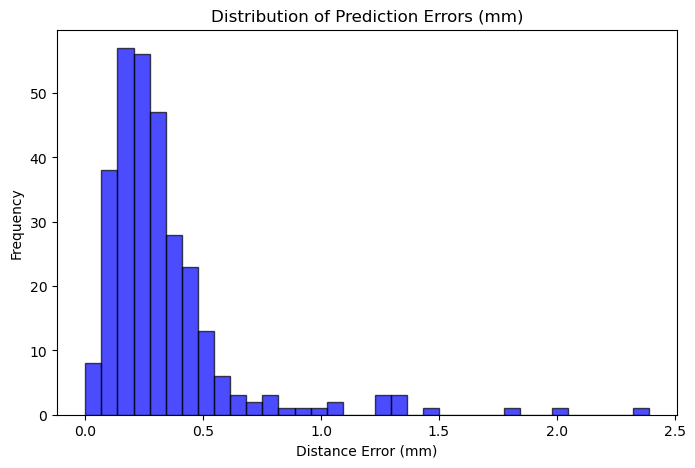

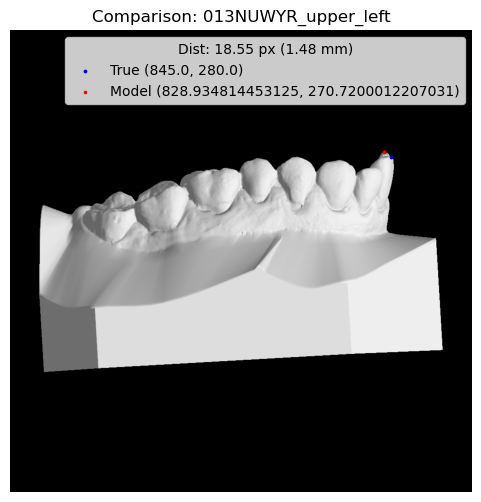

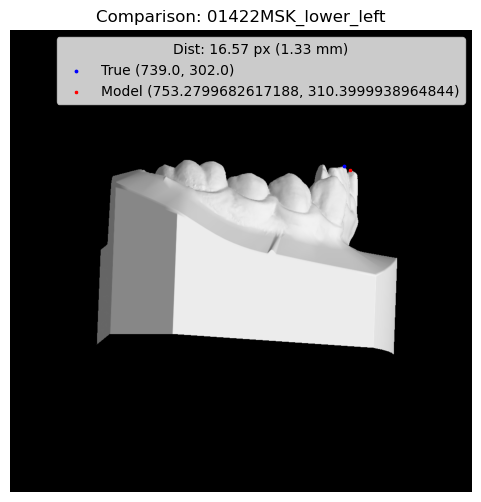

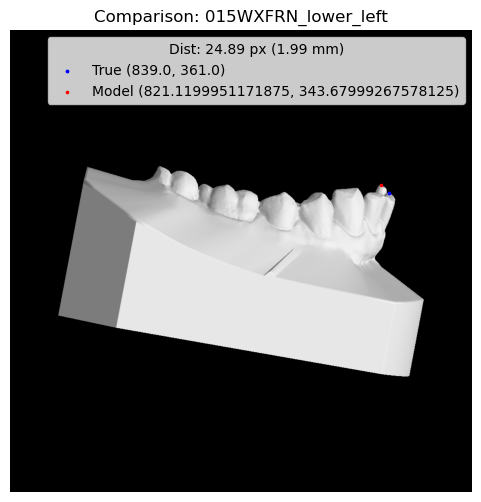

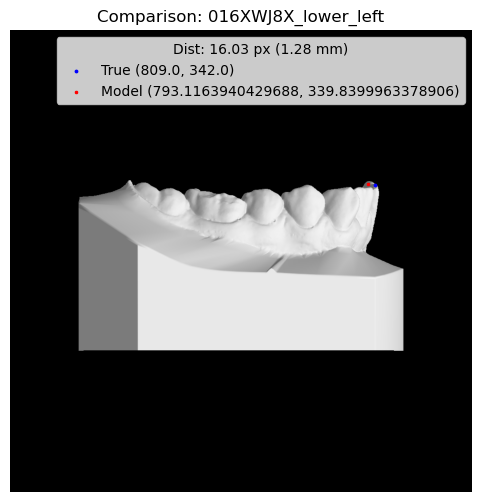

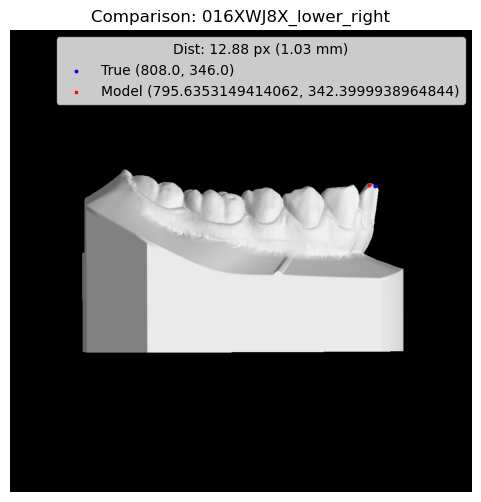

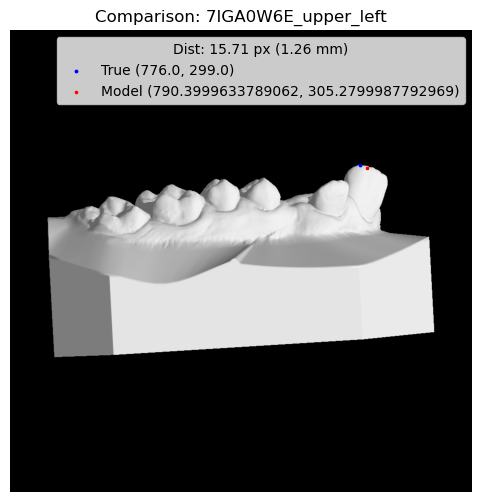

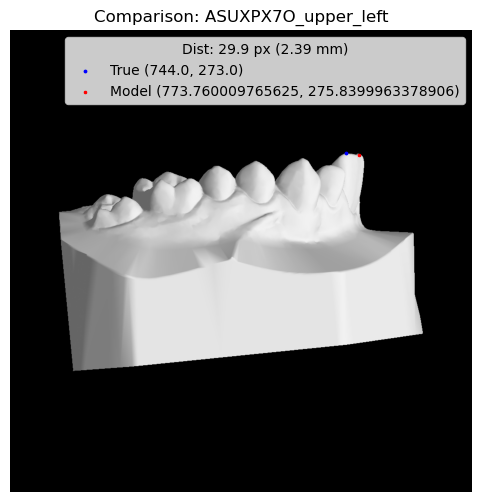

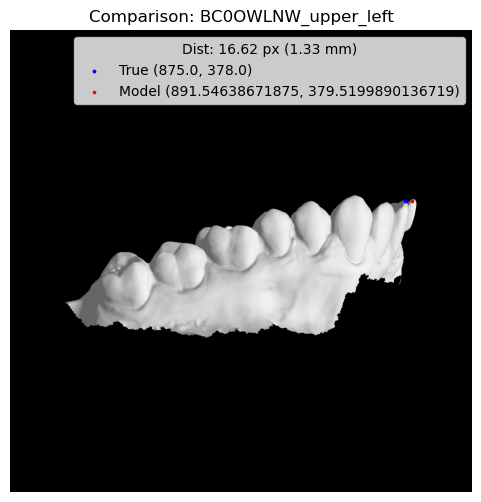

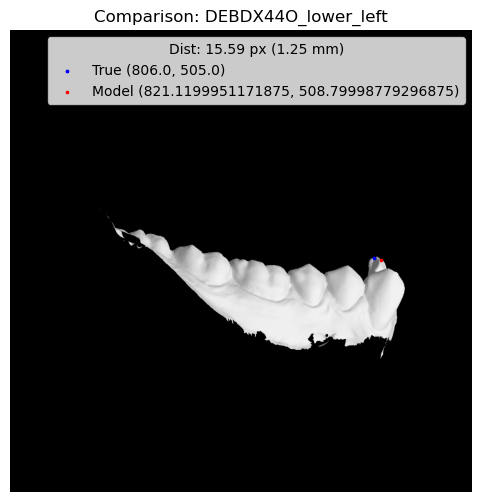

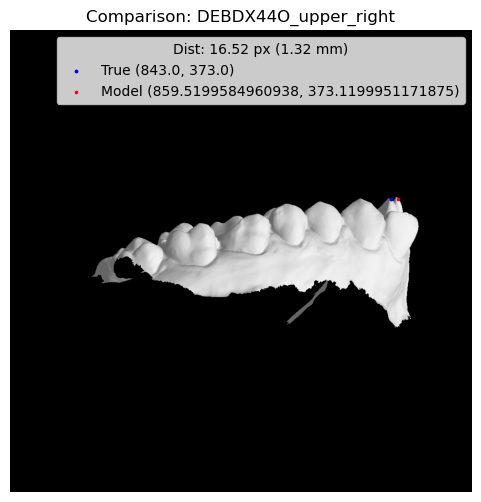

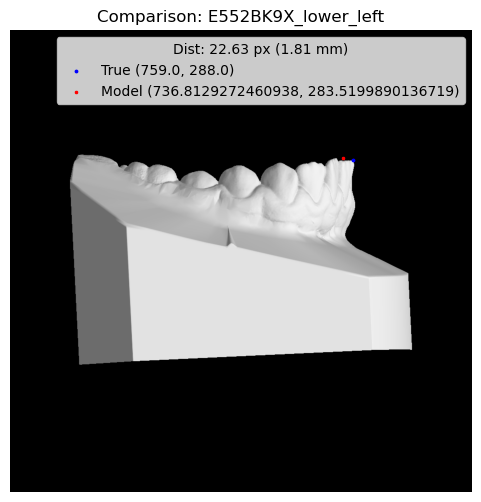

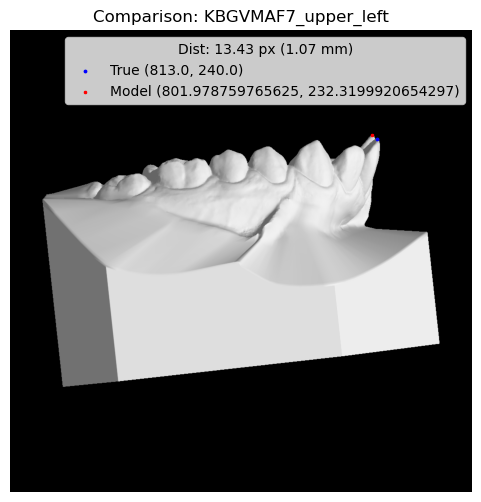

In [17]:
import csv
import cv2
import matplotlib.pyplot as plt
import os

# === CONFIGURATION ===
matched_predictions_file = os.path.join("..", "Output", "Keypoint Placement", "final_results_with_distance_54999_Nye.csv")
image_folder = os.path.join("..", "..", "Data", "Clean Data", "Overbite Data", "Annotated Test data")
error_threshold_mm = 1.0
PIXEL_TO_MM = 0.08  # In case you want to reverse-calculate
image_extension = ".png"  # Change to .jpg if needed

# === LOAD DATA FROM CSV ===
distances_mm = []
high_error_rows = []

with open(matched_predictions_file, mode="r", newline="") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row 1
    next(reader)  # Skip header row 2

    for row in reader:
        filename, true_x, true_y, pred_x, pred_y, euc_dist, mm_dist = row
        mm_dist = float(mm_dist)
        distances_mm.append(mm_dist)

        if mm_dist > error_threshold_mm:
            high_error_rows.append({
                "filename": filename,
                "true_x": float(true_x),
                "true_y": float(true_y),
                "pred_x": float(pred_x),
                "pred_y": float(pred_y),
                "euc_dist": float(euc_dist),
                "mm_dist": mm_dist
            })

# === CONFIGURATION ===
exclude_outliers = True
max_error_for_histogram = 40.0  # mm – only relevant if exclude_outliers is True


# === PLOT HISTOGRAM ===
if exclude_outliers:
    distances_for_hist = [d for d in distances_mm if d <= max_error_for_histogram]
    print(f"📉 Excluding outliers > {max_error_for_histogram} mm. Showing {len(distances_for_hist)} entries.")
else:
    distances_for_hist = distances_mm
    print(f"📊 Showing all {len(distances_mm)} entries in histogram.")

plt.figure(figsize=(8, 5))
plt.hist(distances_for_hist, bins=35, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Distance Error (mm)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (mm)")
plt.show()

# === DISPLAY HIGH-ERROR IMAGES ===
for row in high_error_rows:
    filename = row["filename"]
    img_path = os.path.join(image_folder, filename + image_extension)

    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.scatter(row["true_x"], row["true_y"], color="blue", marker="o", s=3, label=f"True ({row['true_x']}, {row['true_y']})")
    plt.scatter(row["pred_x"], row["pred_y"], color="red", marker="x", s=3, label=f"Model ({row['pred_x']}, {row['pred_y']})")
    plt.legend(title=f"Dist: {row['euc_dist']} px ({row['mm_dist']} mm)")
    plt.title(f"Comparison: {filename}")
    plt.axis('off')
    plt.show()
